**Skin Lesion Classification of balanced segmented images using EfficientNetB2**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  1 12:35:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Loading files from Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing the required libraries**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB2
from PIL import Image
import cv2  
from google.colab.patches import cv2_imshow

In [4]:
import pathlib
root_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote"
data_dir = pathlib.Path(root_path)

**Splitting the data into training and validation**

In [5]:
batch_size=64

In [6]:
img_height,img_width=256,256
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 61875 files belonging to 8 classes.
Using 49500 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 61875 files belonging to 8 classes.
Using 12375 files for validation.


In [8]:
classnames = train_ds.class_names
classnames

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

**Visualizing the data**

In [9]:
import cv2  
from google.colab.patches import cv2_imshow

(-0.5, 255.5, 255.5, -0.5)

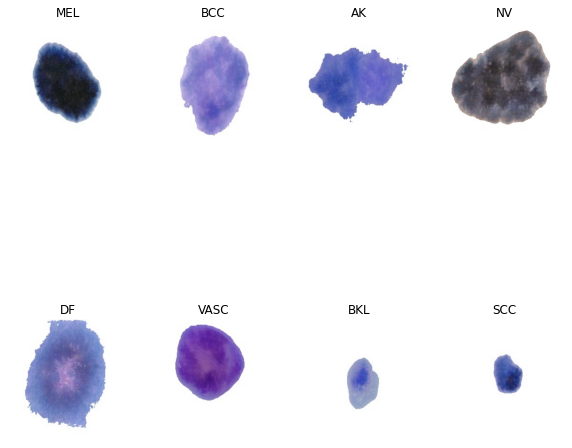

In [11]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,4,figsize=[10,10])

ax[0, 0].title.set_text('MEL')
ax[0, 1].title.set_text('BCC')
ax[0, 2].title.set_text('AK')
ax[0, 3].title.set_text('NV')

img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/MEL/ICIS_resampled_4432.jpg')
ax[0, 0].imshow(img)
ax[0, 0].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/BCC/ICIS_resampled_869.jpg')
ax[0, 1].imshow(img)
ax[0, 1].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/AK/ICIS_resampled_9.jpg')
ax[0, 2].imshow(img)
ax[0, 2].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/NV/ISIC_0000000.jpg')
ax[0, 3].imshow(img)
ax[0, 3].axis("off")

ax[1, 0].title.set_text('DF')
ax[1, 1].title.set_text('VASC')
ax[1, 2].title.set_text('BKL')
ax[1, 3].title.set_text('SCC')


img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/DF/ICIS_resampled_4191.jpg')
ax[1, 0].imshow(img)
ax[1, 0].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/VASC/ICIS_resampled_12204.jpg')
ax[1, 1].imshow(img)
ax[1, 1].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/BKL/ICIS_resampled_9583.jpg')
ax[1, 2].imshow(img)
ax[1, 2].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/segmented_smote/SCC/ICIS_resampled_8954.jpg')
ax[1, 3].imshow(img)
ax[1, 3].axis("off")

**Training the model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = layers.Input(shape=(256, 256, 3))
x = img_augmentation(inputs)  
model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(8, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#10 epochs

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
774/774 [==============================] - 875s 1s/step - loss: 1.2977 - accuracy: 0.5300 - val_loss: 1.3032 - val_accuracy: 0.5257
Epoch 2/10
774/774 [==============================] - 157s 202ms/step - loss: 1.3023 - accuracy: 0.5297 - val_loss: 1.3063 - val_accuracy: 0.5327
Epoch 3/10
774/774 [==============================] - 157s 202ms/step - loss: 1.3113 - accuracy: 0.5253 - val_loss: 1.4952 - val_accuracy: 0.4918
Epoch 4/10
774/774 [==============================] - 156s 201ms/step - loss: 1.3155 - accuracy: 0.5238 - val_loss: 1.2767 - val_accuracy: 0.5315
Epoch 5/10
774/774 [==============================] - 157s 201ms/step - loss: 1.3150 - accuracy: 0.5264 - val_loss: 1.2639 - val_accuracy: 0.5440
Epoch 6/10
774/774 [==============================] - 157s 201ms/step - loss: 1.3303 - accuracy: 0.5199 - val_loss: 1.2574 - val_accuracy: 0.5376
Epoch 7/10
774/774 [==============================] - 157s 201ms/step - loss: 1.3320 - accuracy: 0.5191 - val_loss: 1.3515 - va

In [ ]:
#20 epochs

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
774/774 [==============================] - 156s 201ms/step - loss: 1.3298 - accuracy: 0.5196 - val_loss: 1.3868 - val_accuracy: 0.5181
Epoch 2/10
774/774 [==============================] - 156s 201ms/step - loss: 1.3272 - accuracy: 0.5200 - val_loss: 1.3323 - val_accuracy: 0.5342
Epoch 3/10
774/774 [==============================] - 157s 201ms/step - loss: 1.3367 - accuracy: 0.5181 - val_loss: 1.4643 - val_accuracy: 0.5016
Epoch 4/10
774/774 [==============================] - 156s 201ms/step - loss: 1.3325 - accuracy: 0.5227 - val_loss: 1.4053 - val_accuracy: 0.5013
Epoch 5/10
774/774 [==============================] - 156s 201ms/step - loss: 1.3342 - accuracy: 0.5179 - val_loss: 1.4165 - val_accuracy: 0.4966
Epoch 6/10
774/774 [==============================] - 157s 202ms/step - loss: 1.3328 - accuracy: 0.5182 - val_loss: 1.3249 - val_accuracy: 0.5207
Epoch 7/10
774/774 [==============================] - 156s 201ms/step - loss: 1.3312 - accuracy: 0.5180 - val_loss: 1.2780 -

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/20_segmented_smote.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/20_segmented_smote.h5')

In [ ]:
#30 epochs

model.trainable = True
epochs=10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
774/774 [==============================] - 692s 868ms/step - loss: 1.0349 - accuracy: 0.6168 - val_loss: 0.8116 - val_accuracy: 0.6937
Epoch 2/10
774/774 [==============================] - 672s 868ms/step - loss: 0.7527 - accuracy: 0.7184 - val_loss: 0.6981 - val_accuracy: 0.7354
Epoch 3/10
774/774 [==============================] - 671s 866ms/step - loss: 0.6371 - accuracy: 0.7610 - val_loss: 0.6103 - val_accuracy: 0.7707
Epoch 4/10
774/774 [==============================] - 672s 867ms/step - loss: 0.5499 - accuracy: 0.7969 - val_loss: 0.5855 - val_accuracy: 0.7806
Epoch 5/10
774/774 [==============================] - 673s 869ms/step - loss: 0.4836 - accuracy: 0.8204 - val_loss: 0.5090 - val_accuracy: 0.8113
Epoch 6/10
774/774 [==============================] - 672s 867ms/step - loss: 0.4260 - accuracy: 0.8422 - val_loss: 0.4562 - val_accuracy: 0.8288
Epoch 7/10
774/774 [==============================] - 671s 866ms/step - loss: 0.3784 - accuracy: 0.8614 - val_loss: 0.4523 -

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/30_segmented_smote.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
#35 epochs

epochs=5
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/5
774/774 [==============================] - 672s 868ms/step - loss: 0.2351 - accuracy: 0.9148 - val_loss: 0.3766 - val_accuracy: 0.8674
Epoch 2/5
774/774 [==============================] - 673s 868ms/step - loss: 0.2120 - accuracy: 0.9224 - val_loss: 0.3562 - val_accuracy: 0.8789
Epoch 3/5
774/774 [==============================] - 673s 868ms/step - loss: 0.1893 - accuracy: 0.9311 - val_loss: 0.3701 - val_accuracy: 0.8773
Epoch 4/5
774/774 [==============================] - 673s 869ms/step - loss: 0.1695 - accuracy: 0.9387 - val_loss: 0.3523 - val_accuracy: 0.8825
Epoch 5/5
774/774 [==============================] - 673s 869ms/step - loss: 0.1569 - accuracy: 0.9429 - val_loss: 0.3475 - val_accuracy: 0.8870


In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/35_segmented_smote.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/35_segmented_smote.h5')

In [ ]:
#50 epochs

epochs=15
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/15
774/774 [==============================] - 1590s 2s/step - loss: 0.1317 - accuracy: 0.9543 - val_loss: 0.3317 - val_accuracy: 0.8962
Epoch 2/15
774/774 [==============================] - 673s 869ms/step - loss: 0.1232 - accuracy: 0.9555 - val_loss: 0.3441 - val_accuracy: 0.8941
Epoch 3/15
774/774 [==============================] - 673s 869ms/step - loss: 0.1138 - accuracy: 0.9590 - val_loss: 0.3495 - val_accuracy: 0.8943
Epoch 4/15
774/774 [==============================] - 674s 870ms/step - loss: 0.1026 - accuracy: 0.9632 - val_loss: 0.3495 - val_accuracy: 0.8985
Epoch 5/15
774/774 [==============================] - 673s 869ms/step - loss: 0.1012 - accuracy: 0.9634 - val_loss: 0.3422 - val_accuracy: 0.8972
Epoch 6/15
774/774 [==============================] - 672s 868ms/step - loss: 0.0887 - accuracy: 0.9685 - val_loss: 0.3610 - val_accuracy: 0.8992
Epoch 7/15
774/774 [==============================] - 672s 868ms/step - loss: 0.0845 - accuracy: 0.9699 - val_loss: 0.3461 - v

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/50_segmented_smote.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


**Validating the model**

In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/50_segmented_smote.h5')

In [ ]:
y_val = np.zeros(12375, dtype=object)
x_val = np.zeros([12375, 256, 256, 3])
i=0
j=0

for x,y in val_ds:
  for k in x:
    x_val[j, :,:] = k
    j+=1
  for p in y:
    y_val[i] = p
    i+=1

y_label = np.empty(12375, dtype=object)
for i in range(len(y_val)):
  y_label[i] = np.array(y_val[i])

In [ ]:
pred=model.predict(x_val,batch_size=64, verbose=1)

194/194 [==============================] - 180s 917ms/step


In [ ]:
y_true=[]
for i in range(len(y_label)):
  y_true.append(classnames[y_label[i]])

In [ ]:
output_class=[]
for i in range(len(pred)):
  output_class.append(classnames[np.argmax(pred[i])])

**Displaying few predicted samples**

In [ ]:
for i in range(50):
  print("\nImage : ", i+1)
  cv2_imshow(x_val[i])
  print("The actual class is", y_true[i])
  print("The predicted class is", output_class[i]) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Crct_Counter={'AK':0,'MEL':0,'BCC':0,'NV':0,'BKL':0,'DF':0,'VASC':0,'SCC':0}
Total_Counter={'AK':0,'MEL':0,'BCC':0,'NV':0,'BKL':0,'DF':0,'VASC':0,'SCC':0}
for i in range(len(pred)):
  Total_Counter[y_true[i]]+=1
  if(y_true[i]==output_class[i]):
    Crct_Counter[y_true[i]]+=1

**Displaying class-wise accuracies**

In [ ]:
print("Class_name \t\t Crct_pred \t\t  tot_images \t\t Accuracy")
print("AK\t\t\t",Crct_Counter['AK'],"\t\t\t ",Total_Counter['AK'],"\t\t\t",round(Crct_Counter['AK']/Total_Counter['AK'],2))
print("MEL\t\t\t",Crct_Counter['MEL'],"\t\t\t ",Total_Counter['MEL'],"\t\t\t",round(Crct_Counter['MEL']/Total_Counter['MEL'],2))
print("BCC\t\t\t",Crct_Counter['BCC'],"\t\t\t ",Total_Counter['BCC'],"\t\t\t",round(Crct_Counter['BCC']/Total_Counter['BCC'],2))
print("NV\t\t\t",Crct_Counter['NV'],"\t\t\t ",Total_Counter['NV'],"\t\t\t",round(Crct_Counter['NV']/Total_Counter['NV'],2))
print("BKL\t\t\t",Crct_Counter['BKL'],"\t\t\t ",Total_Counter['BKL'],"\t\t\t",round(Crct_Counter['BKL']/Total_Counter['BKL'],2))
print("DF\t\t\t",Crct_Counter['DF'],"\t\t\t ",Total_Counter['DF'],"\t\t\t",round(Crct_Counter['DF']/Total_Counter['DF'],2))
print("VASC\t\t\t",Crct_Counter['VASC'],"\t\t\t ",Total_Counter['VASC'],"\t\t\t",round(Crct_Counter['VASC']/Total_Counter['VASC'],2))
print("SCC\t\t\t",Crct_Counter['SCC'],"\t\t\t ",Total_Counter['SCC'],"\t\t\t",round(Crct_Counter['SCC']/Total_Counter['SCC'],2))

Class_name 		 Crct_pred 		  tot_images 		 Accuracy
AK			 1279 			  1405 			 0.91
MEL			 1177 			  1403 			 0.84
BCC			 1076 			  1420 			 0.76
NV			 2552 			  2552 			 1.0
BKL			 1180 			  1428 			 0.83
DF			 1332 			  1351 			 0.99
VASC			 1403 			  1413 			 0.99
SCC			 1273 			  1403 			 0.91


**Displaying classification report**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
print(classification_report(y_true, output_class, target_names=target_names))

              precision    recall  f1-score   support

          AK       0.86      0.91      0.89      1405
         BCC       0.87      0.76      0.81      1420
         BKL       0.77      0.83      0.80      1428
          DF       0.97      0.99      0.98      1351
         MEL       0.83      0.84      0.83      1403
          NV       1.00      1.00      1.00      2552
         SCC       0.95      0.91      0.93      1403
        VASC       0.98      0.99      0.99      1413

    accuracy                           0.91     12375
   macro avg       0.90      0.90      0.90     12375
weighted avg       0.91      0.91      0.91     12375



**Displaying confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, output_class, labels=target_names)

array([[1279,   49,   41,    6,   16,    0,   14,    0],
       [  89, 1076,  109,   15,   81,    2,   37,   11],
       [  64,   35, 1180,   12,  116,    0,   16,    5],
       [   0,    6,    7, 1332,    5,    0,    1,    0],
       [  27,   35,  146,    5, 1177,    2,    4,    7],
       [   0,    0,    0,    0,    0, 2552,    0,    0],
       [  21,   29,   49,    2,   29,    0, 1273,    0],
       [   1,    3,    0,    3,    1,    1,    1, 1403]])